## Idaho Image Access via GBDXTools

This notebook demos a gbdxtools interface to Idaho Image data. The new interface allows users to provide catalog ids and idaho ids to access raw data for entire scenes and/or AOIs. The underlying code provides a dask based deferred array that is fetched from disk on demand into a numpy ndarray for usage.  

In [1]:
from gbdxtools import Interface
gbdx = Interface()

import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

def plot_pan(data):
    f, ax1 = plt.subplots(1, figsize=(20,10))
    ax1.axis('off')
    plt.imshow(data[0,:,:], cmap="Greys_r")
    plt.show()

def plot(data, stretch=[2,98]):
    data = data.compute()
    f, ax1 = plt.subplots(1, figsize=(20,10))
    ax1.axis('off')
    data = data.astype(np.float32)
    data = np.rollaxis(data, 0, 3)
    lims = np.percentile(data,stretch,axis=(0,1))
    for x in xrange(len(data[0,0,:])):
        top = lims[:,x][1]
        bottom = lims[:,x][0]
        data[:,:,x] = (data[:,:,x]-bottom)/float(top-bottom)
    data = np.clip(data,0,1)
    plt.imshow(data,interpolation='nearest')   
    plt.show(block=False)

### We can pass an Idaho Image id to the `gbdx.ipeimage` class

This initializes an image that represent the full extent of the idaho image, users can optionally pass a BBOX, GeoJSON Geometry, or WKT to define an AOI.

One thing to note is that no data are fetched until they need to be. 

In [2]:
# Provide virtual access to the full Idaho Image 
img = gbdx.ipeimage('11f19495-eb37-4da6-8891-03f036bda453', acomp=True, gsd=.3)

# select RGB bands, still no data fetched yet
rgb = img[[4,2,1], ...]
print rgb.shape

(3, 5376, 7936)


### Provides access to spatial metadata, data types, sizes, etc. 

In [3]:
img.metadata()

{'count': 8,
 'crs': CRS({'init': u'epsg:4326'}),
 'driver': u'VRT',
 'dtype': 'float32',
 'height': 5376,
 'nodata': None,
 'transform': Affine(1.79931728351e-05, 0.0, -110.95386207,
       0.0, -1.79931728351e-05, 32.21426916),
 'width': 7936}

### A BBOX can be used to define an AOI on the image

In [4]:
aoi = img.aoi(bbox=[-110.85299491882326,32.167148499672855,-110.84870338439943,32.170236308395644])
print aoi.shape

(8, 512, 768)


### The actual data are not fetched until we want to use the data, like making a plot

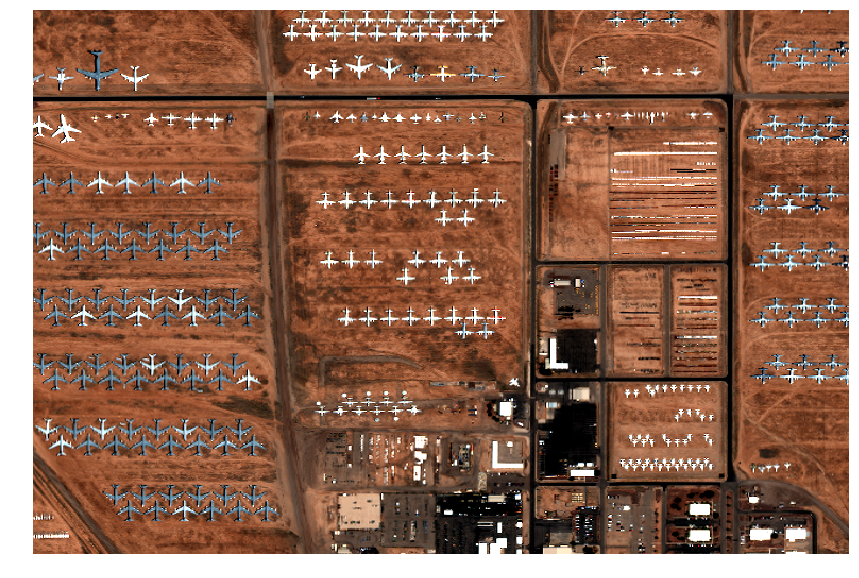

In [5]:
aoi_rgb = aoi[[4,2,1], ...]
plot(aoi_rgb)

### GeoTIFF images can be created via the `to_geotiff` method in `gbdxtools.ipe.io_utils`

In [6]:
from gbdxtools.ipe.io import to_geotiff

to_geotiff(aoi, path='airplanes.tif', proj="EPSG:26913")

!gdalinfo 'airplanes.tif'

fetching data
Driver: GTiff/GeoTIFF
Files: airplanes.tif
Size is 768, 512
Coordinate System is:
PROJCS["NAD83 / UTM zone 13N",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101,
                AUTHORITY["EPSG","7019"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6269"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-105],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","26913"]]
Origin = (-110.852994918823256,32.170236308395644)
Pixel Size = (0.000005587935448

# Using a Catalog ID

In place of idaho ids we can also access raw data via a `catalog_id` which represents an entire strip of imagery with many parts. When we use a catalog_id the underlying raw data still come from IPE/Idaho. 

In [7]:
cat_id = '104001000D7A8600'
bounds = [-110.85299491882326,32.167148499672855,-110.84870338439943,32.170236308395644] 

img = gbdx.image(cat_id) # pansharpen=True|False acomp=True|False projection="WGS84|UTM", gsd=float

aoi = img.aoi(bbox=bounds, band_type='Pan') # band_type='MS|Pan'
print aoi.shape

(1, 1280, 1536)


### Catalog ID based images behave the same IpeImages

Data are not fetched until its required, and we have the added benefit of specifying different image types such as Multispectral, Panchromatic, and Pansharpened.

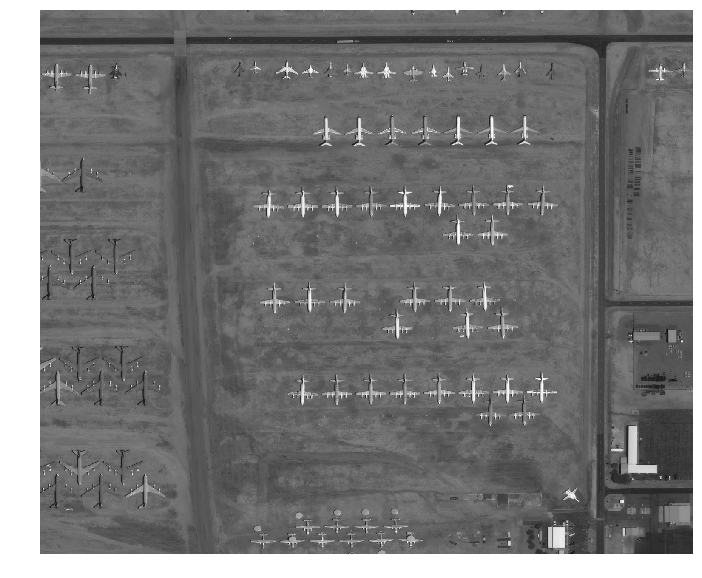

In [8]:
plot_pan(aoi)

### Pansharpening happens via underlying IPE Graphs

In [9]:
img = gbdx.image(cat_id, pansharpen=True, acomp=True, gsd=.3)
aoi = img.aoi(bounds)
aoi.shape

(8, 1280, 1536)

In [10]:
sharpened = aoi[[4,2,1], ...]
sharpened.dtype

dtype('uint16')

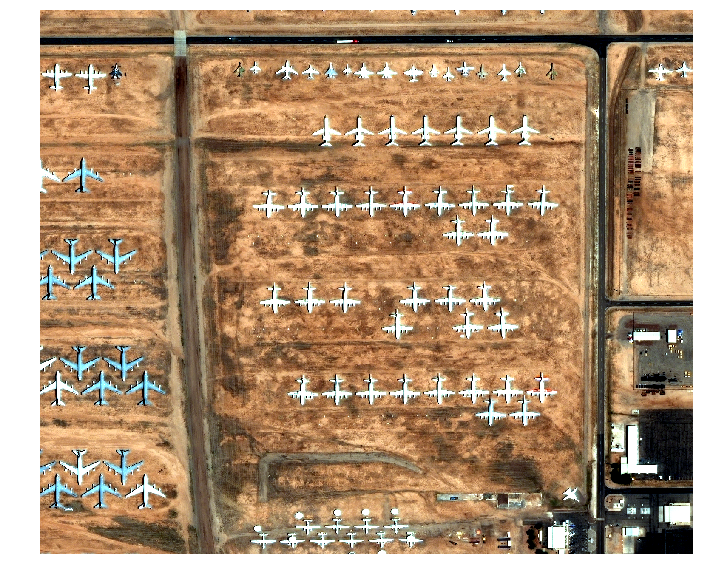

In [11]:
plot(sharpened, stretch=[2,96])

### Rasterio like access

When we want to process entire images we can open datasets via python context managers. This allows the potential to iterate over windows of data for the entire scene.

In [15]:
with aoi.open() as src:
    print 'Bounds', list(src.bounds)
    print 'N-blocks', len([x for x,w in src.block_windows()])

Bounds [-110.95369461, 32.1213215077687, -110.81446593590745, 32.21427564]
N-blocks 39204
